Outcome variables:

- depression
- anxiety
- parenting stress

Confounders

- mental health treatment
- Child level variables
    - expressive language
    - ADOS
- DAS (relationships)

Start with time 1 versus time 3
- finished at least 10 sessions (`finish_tx`)

Similar age and location of kids

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns

import theano.tensor as tt
from theano import shared

sns.set(context='notebook', style='ticks')

/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
mbsr_raw = pd.read_csv('../data/MBSR Data Set 3-28-18 for analysis.csv', index_col=0, na_values=[' '],
                       parse_dates=['child_dob', 'ados_date', 'startdate'])
mbsr_raw.tail()

,finish_tx,parentfinish_t6,childfinish_t6,child_dob,ados_date,age_ados,ados_module,ados_new_algorithm,ados_severity,ados_concern,...,DescribeT5,AwareT5,NonjudgeT5,NonreactT5,FFMQT6,ObserveT6,DescribeT6,AwareT6,NonjudgeT6,NonreactT6
study_id,,,,,,,,,,,,,,,,,,,,,
59,1,1.0,1,2015-05-07,2017-04-04,1.91,3.0,17.0,NaN,3.0,...,NaN,NaN,NaN,NaN,126.0,16.0,33.0,28.0,29.0,20.0
60,1,0.0,1,2015-02-17,2017-04-21,2.17,3.0,26.0,NaN,3.0,...,26.0,33.0,28.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
61,0,0.0,0,2014-10-20,2017-04-22,2.51,3.0,17.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,1,1.0,1,2014-12-06,2017-05-22,2.46,3.0,18.0,NaN,3.0,...,25.0,32.0,32.0,14.0,117.0,19.0,21.0,28.0,33.0,16.0
63,1,1.0,1,2015-03-19,2017-06-26,2.27,3.0,22.0,NaN,3.0,...,27.0,32.0,33.0,17.0,131.0,29.0,24.0,31.0,32.0,15.0


Find the first column label for outcomes

In [3]:
outcome_start = np.argwhere(mbsr_raw.columns=='cbcl1t6').squeeze()

Extract columns to be used in analysis

In [4]:
mbsr_raw.columns[mbsr_raw.columns.str.contains('str')].tolist()

[]

In [5]:
columns_to_keep = (['finish_tx', 'age_ados', 'ados_new_algorithm', 'group_', 
                    'startdate', 'age_begin', 'expressiveraw', 'dq7f'] 
                   + mbsr_raw.columns[outcome_start:].tolist())
mbsr_data = mbsr_raw[columns_to_keep].query('finish_tx==1').copy()
mbsr_data.head()

,finish_tx,age_ados,ados_new_algorithm,group_,startdate,age_begin,expressiveraw,dq7f,cbcl1t6,cbcl2t6,...,DescribeT5,AwareT5,NonjudgeT5,NonreactT5,FFMQT6,ObserveT6,DescribeT6,AwareT6,NonjudgeT6,NonreactT6
study_id,,,,,,,,,,,,,,,,,,,,,
1,1,2.46,14.0,1,2015-04-02,2.52,19.0,NaN,0.0,50.0,...,31.0,39.0,29.0,17.0,133.0,16.0,31.0,40.0,31.0,15.0
2,1,2.94,12.0,1,2015-04-02,2.52,47.0,NaN,1.0,50.0,...,37.0,32.0,36.0,20.0,NaN,16.0,36.0,34.0,NaN,16.0
3,1,2.82,24.0,0,2015-04-02,2.86,34.0,NaN,3.0,55.0,...,25.0,32.0,36.0,20.0,126.0,12.0,21.0,31.0,36.0,26.0
4,1,2.49,24.0,1,2015-05-01,2.57,13.0,NaN,1.0,50.0,...,35.0,40.0,36.0,21.0,165.0,30.0,35.0,40.0,35.0,25.0
5,1,2.52,20.0,1,2015-05-08,2.55,12.0,NaN,2.0,51.0,...,22.0,32.0,31.0,13.0,122.0,22.0,22.0,33.0,32.0,13.0


In [6]:
mbsr_data.shape

(54, 153)

Create columns for change in outcome

Beck anxiety:

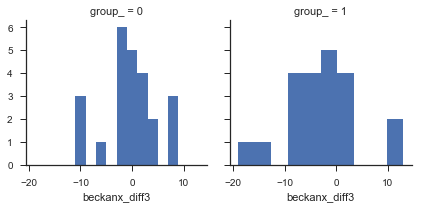

In [7]:
mbsr_data['beckanx_diff3'] = mbsr_data['beckanxT3'] - mbsr_data['beckanxT1']
g = sns.FacetGrid(mbsr_data, col='group_')
g.map(plt.hist, 'beckanx_diff3');

PSI:

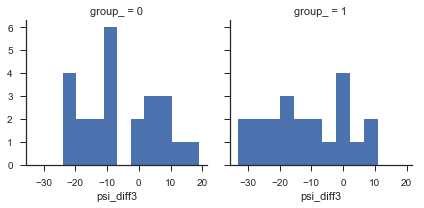

In [8]:
mbsr_data['psi_diff3'] = mbsr_data['psitot3'] - mbsr_data['psitot']
g = sns.FacetGrid(mbsr_data, col='group_')
g.map(plt.hist, 'psi_diff3');

parent-child dysfunctional interaction

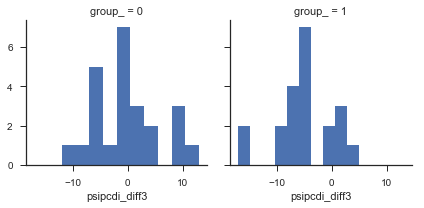

In [9]:
mbsr_data['psipcdi_diff3'] = mbsr_data['psipcdi3'] - mbsr_data['psipcdi']
g = sns.FacetGrid(mbsr_data, col='group_')
g.map(plt.hist, 'psipcdi_diff3');

Depression:

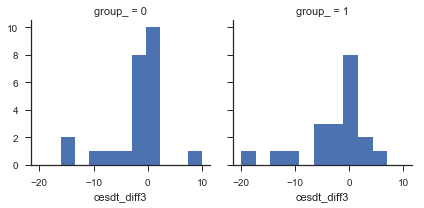

In [10]:
mbsr_data['cesdt_diff3'] = mbsr_data['cesdt3'] - mbsr_data['cesdt1']
g = sns.FacetGrid(mbsr_data, col='group_')
g.map(plt.hist, 'cesdt_diff3');

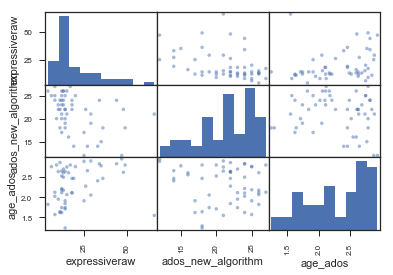

In [11]:
pd.plotting.scatter_matrix(mbsr_data[['expressiveraw', 'ados_new_algorithm', 'age_ados']]);

## Model specification

In [12]:
def create_outcome_model(outcome, cols, dataset=mbsr_data, center=True):
    
    _dataset = dataset.dropna(subset=[outcome]+cols).copy()
    
    if center:
        X = shared((_dataset[cols] - _dataset[cols].mean()).values)
    else:
        X = shared(_dataset[cols].values)
    
    y = shared(_dataset[outcome].values)
    
    
    with pm.Model() as mod:
        
        # Mean effect at covariate baselines
        μ = pm.Normal('μ', 0, sd=10)
        
        # Covariate coefficients
        β = pm.Normal('β', 0, sd=5, shape=len(cols))
        
        # Expected outcome
        θ = μ + tt.dot(X, β)

        # Error
        σ = pm.HalfCauchy('σ', 1)
        obs_diff = pm.Normal('obs_diff', θ, sd=σ, observed=y)
        
    return mod

### PSIPCDI model

Create model with specified covariates and `psipcdi_diff3` outcome

In [17]:
model_psipcdi = create_outcome_model('psipcdi_diff3', ['group_', 'expressiveraw', 'ados_new_algorithm'])

Fit the model using MCMC

In [18]:
with model_psipcdi:
    
    trace_psipcdi = pm.sample(1000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ_log__, β, μ]
100%|██████████| 3000/3000 [00:03<00:00, 891.18it/s] 


These are posterior estimates of parameters. $\mu$ is the treatement effect at mean values of covariates, while the $\beta$ values are the covariate effects (here, expressive language and ADOS). The green lines indicate zero, so you can see that the treatment effect is negative with more than 99% probability.

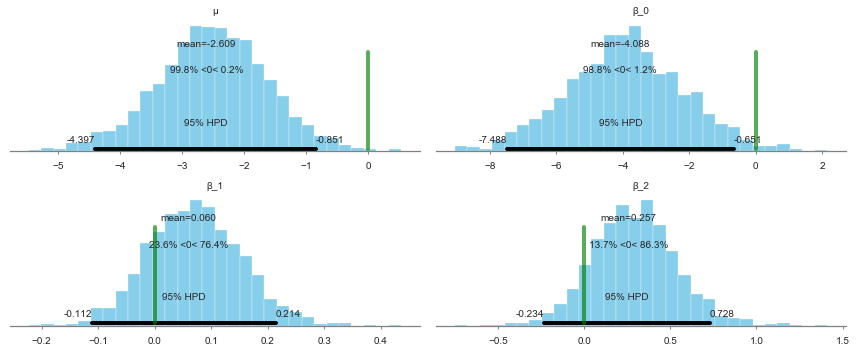

In [19]:
pm.plot_posterior(trace_psipcdi, varnames=['μ', 'β'], ref_val=0)
plt.tight_layout()

In [20]:
pm.summary(trace_psipcdi).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
μ,-2.61,0.89,0.02,-4.40,-0.85,2326.43,1.0
β__0,-4.09,1.77,0.04,-7.49,-0.65,1656.64,1.0
β__1,0.06,0.08,0.00,-0.11,0.21,1686.82,1.0
β__2,0.26,0.25,0.01,-0.23,0.73,1618.58,1.0
σ,5.83,0.68,0.01,4.65,7.25,1912.85,1.0


The following cells are just model checks to see if there is lack of convergence, or poor model fit.

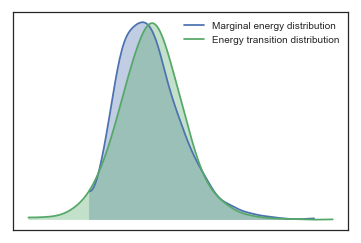

In [21]:
pm.energyplot(trace_psipcdi)

In [22]:
ppc_psipcdi = pm.sample_ppc(trace_psipcdi, samples=500, model=model_psipcdi)

100%|██████████| 500/500 [00:00<00:00, 1680.49it/s]


(array([4., 7., 4., 4., 5., 5., 5., 4., 2., 5.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

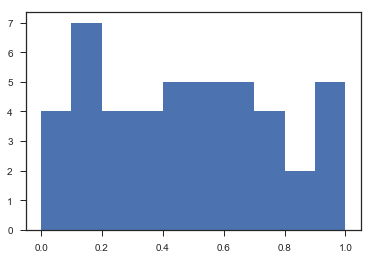

In [23]:
from scipy.stats import percentileofscore

plt.hist([np.round(percentileofscore(x, y)/100, 2) for x, y in zip(ppc_psipcdi['obs_diff'], 
                                                                   mbsr_data.psipcdi_diff3.dropna().values)])

### PSI model

Instantiate model with `psi_diff3` outcome

In [24]:
model_psi = create_outcome_model('psi_diff3', ['group_', 'expressiveraw', 'ados_new_algorithm'])

Fit model with MCMC

In [25]:
with model_psi:
    
    trace_psi = pm.sample(1000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ_log__, β, μ]
100%|██████████| 3000/3000 [00:03<00:00, 845.72it/s] 


Posterior estimates

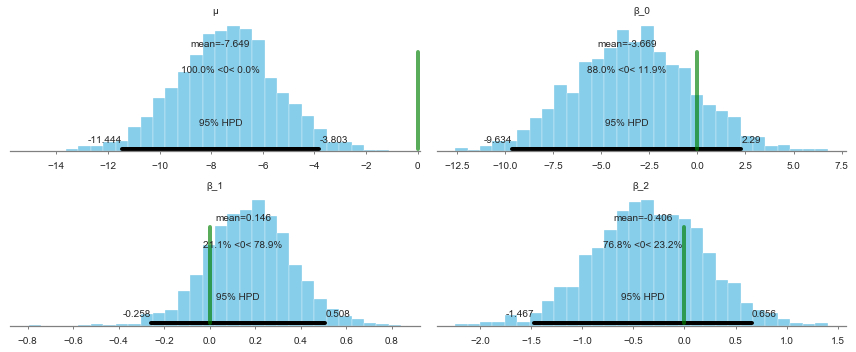

In [26]:
pm.plot_posterior(trace_psi, varnames=['μ', 'β'], ref_val=0);

In [27]:
pm.summary(trace_psi).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
μ,-7.65,1.96,0.03,-11.44,-3.80,3045.67,1.0
β__0,-3.67,3.09,0.06,-9.63,2.29,2003.62,1.0
β__1,0.15,0.19,0.00,-0.26,0.51,1438.20,1.0
β__2,-0.41,0.55,0.01,-1.47,0.66,1481.86,1.0
σ,12.64,1.48,0.04,9.90,15.49,1729.08,1.0


Model checking

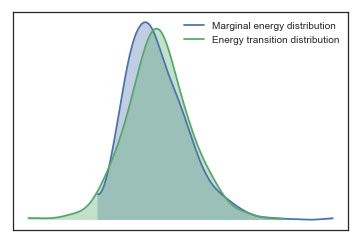

In [28]:
pm.energyplot(trace_psi)

In [29]:
ppc_psi = pm.sample_ppc(trace_psi, samples=500, model=model_psi)

100%|██████████| 500/500 [00:00<00:00, 1640.22it/s]


(array([4., 8., 4., 2., 4., 6., 3., 2., 9., 3.]),
 array([0.   , 0.098, 0.196, 0.294, 0.392, 0.49 , 0.588, 0.686, 0.784,
        0.882, 0.98 ]),
 <a list of 10 Patch objects>)

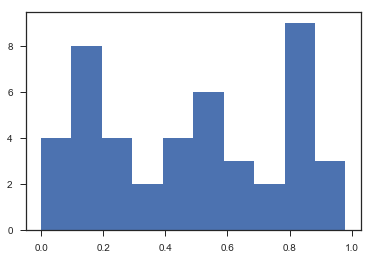

In [30]:
plt.hist([np.round(percentileofscore(x, y)/100, 2) for x, y in zip(ppc_psi['obs_diff'], 
                                                                   mbsr_data.psi_diff3.dropna().values)])

### Beck anxiety model

Instantiate model with `beckanx_diff3` as outcome.

In [31]:
model_beck = create_outcome_model('beckanx_diff3', ['group_', 'expressiveraw', 'ados_new_algorithm'])

Fit model with MCMC

In [32]:
with model_beck:
    
    trace_beck = pm.sample(1000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ_log__, β, μ]
100%|██████████| 3000/3000 [00:03<00:00, 859.76it/s] 


Posterior estimates

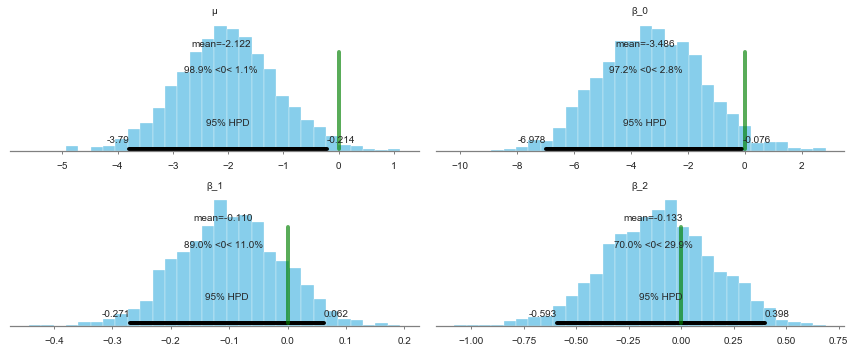

In [33]:
pm.plot_posterior(trace_beck, varnames=['μ', 'β'], ref_val=0);

In [34]:
pm.summary(trace_beck).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
μ,-2.12,0.91,0.02,-3.79,-0.21,2432.69,1.0
β__0,-3.49,1.83,0.04,-6.98,-0.08,1912.26,1.0
β__1,-0.11,0.09,0.00,-0.27,0.06,1412.52,1.0
β__2,-0.13,0.26,0.01,-0.59,0.40,1419.39,1.0
σ,6.03,0.68,0.01,4.82,7.45,1904.46,1.0


Model checking

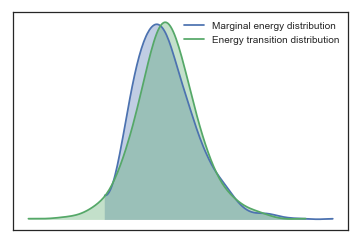

In [35]:
pm.energyplot(trace_beck)

In [36]:
ppc_beck = pm.sample_ppc(trace_beck, samples=500, model=model_beck)

100%|██████████| 500/500 [00:00<00:00, 1676.32it/s]


(array([5., 3., 5., 1., 5., 9., 5., 3., 4., 5.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

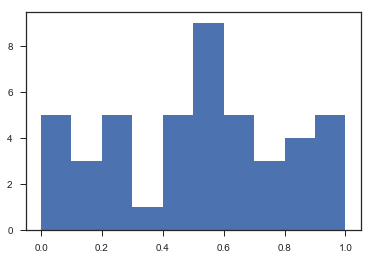

In [37]:
plt.hist([np.round(percentileofscore(x, y)/100, 2) for x, y in zip(ppc_beck['obs_diff'], 
                                                                   mbsr_data.beckanx_diff3.dropna().values)])

### CESDT model

Instantiate model with `cesdt_diff3` as outcome variable.

In [38]:
model_cesdt = create_outcome_model('cesdt_diff3', ['group_', 'expressiveraw', 'ados_new_algorithm'])

Fit model using MCMC

In [39]:
with model_cesdt:
    
    trace_cesdt = pm.sample(1000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ_log__, β, μ]
100%|██████████| 3000/3000 [00:03<00:00, 884.15it/s] 


Posterior estimates

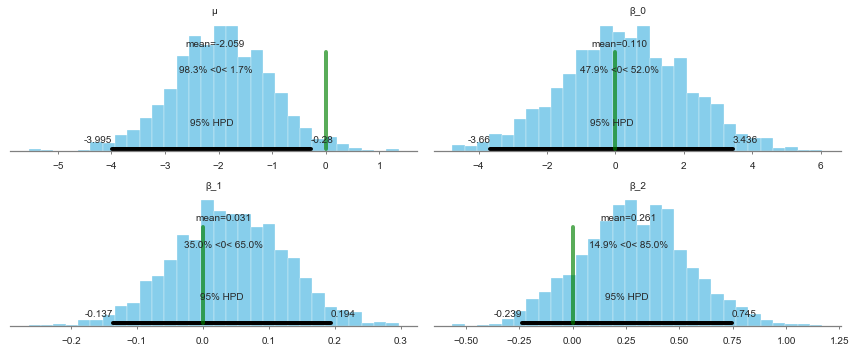

In [40]:
pm.plot_posterior(trace_cesdt, varnames=['μ', 'β'], ref_val=0);

In [41]:
pm.summary(trace_cesdt).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
μ,-2.06,0.93,0.02,-3.99,-0.28,2281.50,1.0
β__0,0.11,1.80,0.04,-3.66,3.44,1810.48,1.0
β__1,0.03,0.08,0.00,-0.14,0.19,1298.08,1.0
β__2,0.26,0.25,0.01,-0.24,0.74,1165.30,1.0
σ,5.86,0.68,0.02,4.58,7.16,1768.77,1.0


Model checking

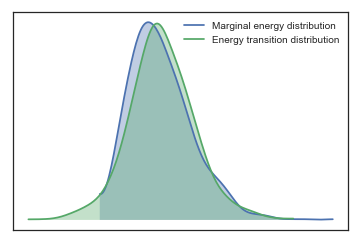

In [42]:
pm.energyplot(trace_cesdt)

In [43]:
ppc_cesdt = pm.sample_ppc(trace_cesdt, samples=500, model=model_beck)

100%|██████████| 500/500 [00:00<00:00, 2590.81it/s]


(array([ 5.,  1.,  1.,  2.,  5., 11., 11.,  5.,  2.,  1.]),
 array([0.   , 0.098, 0.196, 0.294, 0.392, 0.49 , 0.588, 0.686, 0.784,
        0.882, 0.98 ]),
 <a list of 10 Patch objects>)

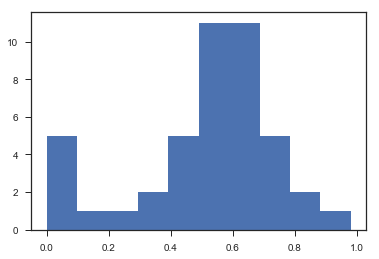

In [44]:
plt.hist([np.round(percentileofscore(x, y)/100, 2) for x, y in zip(ppc_cesdt['obs_diff'], 
                                                                   mbsr_data.cesdt_diff3.dropna().values)])